In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser  = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score

import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim import matutils
from gensim.models import CoherenceModel

from operator import itemgetter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from absa_functions import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

<ipython-input-3-3309e384d275>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [4]:
train_path = 'train.xml'
corpus_df, categories = create_corpus(train_path)

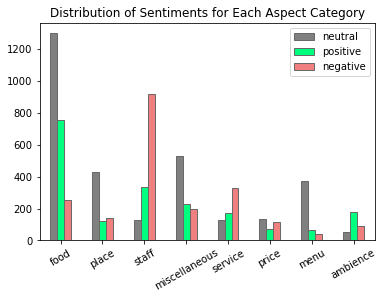

In [5]:
counts = {}
for cat in categories:
    counts.update({cat: dict(corpus_df[f'{cat}'].value_counts())})

count_df = pd.DataFrame(counts).transpose()

count_df.plot(kind = 'bar', color = ['grey', 'springgreen', 'lightcoral'], edgecolor = 'dimgrey')
plt.xticks(rotation = 30);
plt.title('Distribution of Sentiments for Each Aspect Category');

In [6]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
text_data = preprocess_corpus(corpus_df)

In [8]:
dictionary, corpus = create_bagofwords(text_data)

In [9]:
lda_model = gensim.models.ldamodel.LdaModel.load('best_lda_model.gensim')

In [10]:
topic_match_df = apply_lda_to_corpus(lda_model, corpus, corpus_df, categories)
topic_match_df.head()

,food,place,staff,miscellaneous,service,price,menu,ambience,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010992,0.011027,0.010995,0.011039,0.361809,0.011031,0.583107
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.142954,0.017863,0.183491,0.017906,0.396848,0.017879,0.223060
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.011058,0.011047,0.092661,0.011001,0.703141,0.096554,0.074538
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.017860,0.566961,0.190953,0.017876,0.017902,0.017875,0.170572
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.017864,0.423073,0.142856,0.194810,0.017936,0.017862,0.185599


Text(0.5, 1.0, 'Correlation Between Latent Topics and Topic Labels')

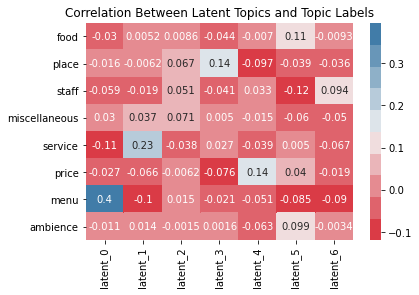

In [11]:
topic_corr = topic_match_df.corr()[[f'latent_{i}' for i in range(0,len(categories) - 1)]][0:len(categories)]

sns.heatmap(topic_corr, annot=True, cmap=sns.diverging_palette(10 ,240, n=10))
plt.title('Correlation Between Latent Topics and Topic Labels')

In [12]:
#numerical mapping for topics in LDA model
topic_map = {0: 'menu', 1: 'service', 2: 'miscellaneous', 3: 'place', 4: 'price', 5: 'food', 6: 'staff'}

In [13]:
lda_df = compile_strong_topics(lda_model, corpus, corpus_df, topic_map)
lda_df.head()

,text,lda_topic
0,"It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.","{'staff': 0.5831622, 'price': 0.36174652}"
1,Hostess was extremely accommodating when we arrived an hour early for our reservation.,"{'price': 0.39687315, 'staff': 0.22304231}"
2,"We were a couple of minutes late for our reservation and minus one guest, but we didn't think we deserved the attitude we got from the hostess.","{'price': 0.7035304, 'food': 0.09655415}"
3,"Though the service might be a little slow, the waitresses are very friendly.","{'service': 0.56698006, 'miscellaneous': 0.19097765}"
4,"Although we arrived at the restaurant 10 min late, the hostess did not have a table for us.","{'service': 0.42308244, 'place': 0.19479752}"


In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
lda_df = sentiment_analysis(lda_df, categories)
lda_df.head()

,text,lda_topic,vader_score,compound_score,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,"It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.","{'staff': 0.5831622, 'price': 0.36174652}","{'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.6369}",0.6369,positive,NaN,NaN,positive,NaN,NaN,positive,NaN,None
1,Hostess was extremely accommodating when we arrived an hour early for our reservation.,"{'price': 0.39687315, 'staff': 0.22304231}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,neutral,NaN,NaN,neutral,NaN,None
2,"We were a couple of minutes late for our reservation and minus one guest, but we didn't think we deserved the attitude we got from the hostess.","{'price': 0.7035304, 'food': 0.09655415}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,neutral,NaN,NaN,NaN,NaN,neutral,NaN,None
3,"Though the service might be a little slow, the waitresses are very friendly.","{'service': 0.56698006, 'miscellaneous': 0.19097765}","{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.5413}",0.5413,positive,NaN,NaN,NaN,positive,positive,NaN,NaN,None
4,"Although we arrived at the restaurant 10 min late, the hostess did not have a table for us.","{'service': 0.42308244, 'place': 0.19479752}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,neutral,NaN,NaN,neutral,NaN,NaN,None


In [17]:
pred_cats_df = create_label_df(corpus_df, categories)
true_cats_df = create_label_df(lda_df, categories)

accuracy = calculate_accuracy(pred_cats_df, true_cats_df)
print(accuracy)

59.88722998729352


In [18]:
pred_cats_enum_df = add_label_col(pred_cats_df, categories)
true_cats_enum_df = add_label_col(true_cats_df, categories)

precision, recall, f1 = calculate_scores(pred_cats_enum_df, true_cats_enum_df)

print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.7602038541200249
Recall: 0.9123252858958069
F1: 0.7996012353574106
